In [1]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the input image size
img_size = 128

# Set the batch size
batch_size = 10

# Set the number of training and validation steps per epoch
train_steps_per_epoch = 3500 // batch_size
val_steps_per_epoch = 500 // batch_size

# Set the number of epochs
epochs = 50

# Create an ImageDataGenerator with data augmentation and normalization for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

# Create an ImageDataGenerator with normalization for the validation set
val_datagen = ImageDataGenerator(rescale=1./255)

# Load the pre-trained ResNet50 model with ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add a new top layer for the specific classification task

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(5, activation='softmax')(x)

# Create the fine-tuned model
model = Model(inputs=base_model.input, outputs=output)

# # Compile the model with categorical crossentropy loss, Adam optimizer, and accuracy metric
# model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])

adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


# Set the training and validation data directories
train_dir = 'split_2_Village/train'
val_dir = 'split_2_Village/val'

# Create the ImageDataGenerators for the training and validation sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical')


2023-04-03 13:32:44.589306: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 13:32:45.386977: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-03 13:32:45.387120: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-03 13:32:45.387127: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Found 3500 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [2]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

In [3]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch)

# Unfreeze the last convolutional block of the VGG16 base model
# for layer in base_model.layers[15:]:
#     layer.trainable = True

# # Continue training the model to fine-tune the weights
# history = model.fit(
#         train_generator,
#         steps_per_epoch=350,
#         epochs=10,
#         validation_data=val_generator,
#         validation_steps=50)

# Set the test data directory
test_dir = 'split_2_Village/test'

# Create an ImageDataGenerator with normalization for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the ImageDataGenerator for the test set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical')

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

Epoch 1/50


2023-04-03 13:32:51.559831: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-04-03 13:32:53.129405: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x5601535d11e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-03 13:32:53.129452: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-04-03 13:32:53.139143: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-03 13:32:53.248659: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


350/350 [==============================] - 18s 37ms/step - loss: 1.6043 - accuracy: 0.2463 - val_loss: 1.4236 - val_accuracy: 0.4120
Epoch 2/50
350/350 [==============================] - 12s 36ms/step - loss: 1.4837 - accuracy: 0.3214 - val_loss: 1.3891 - val_accuracy: 0.3900
Epoch 3/50
350/350 [==============================] - 13s 36ms/step - loss: 1.4285 - accuracy: 0.3503 - val_loss: 1.3582 - val_accuracy: 0.4100
Epoch 4/50
350/350 [==============================] - 12s 35ms/step - loss: 1.4212 - accuracy: 0.3649 - val_loss: 1.5982 - val_accuracy: 0.2200
Epoch 5/50
350/350 [==============================] - 12s 35ms/step - loss: 1.4026 - accuracy: 0.3631 - val_loss: 1.3678 - val_accuracy: 0.4060
Epoch 6/50
350/350 [==============================] - 12s 36ms/step - loss: 1.3837 - accuracy: 0.3811 - val_loss: 1.3049 - val_accuracy: 0.4120
Epoch 7/50
350/350 [==============================] - 12s 36ms/step - loss: 1.3760 - accuracy: 0.3806 - val_loss: 1.6649 - val_accuracy: 0.2280
Epo

100/100 [==============================] - 3s 25ms/step
Test accuracy:19.90


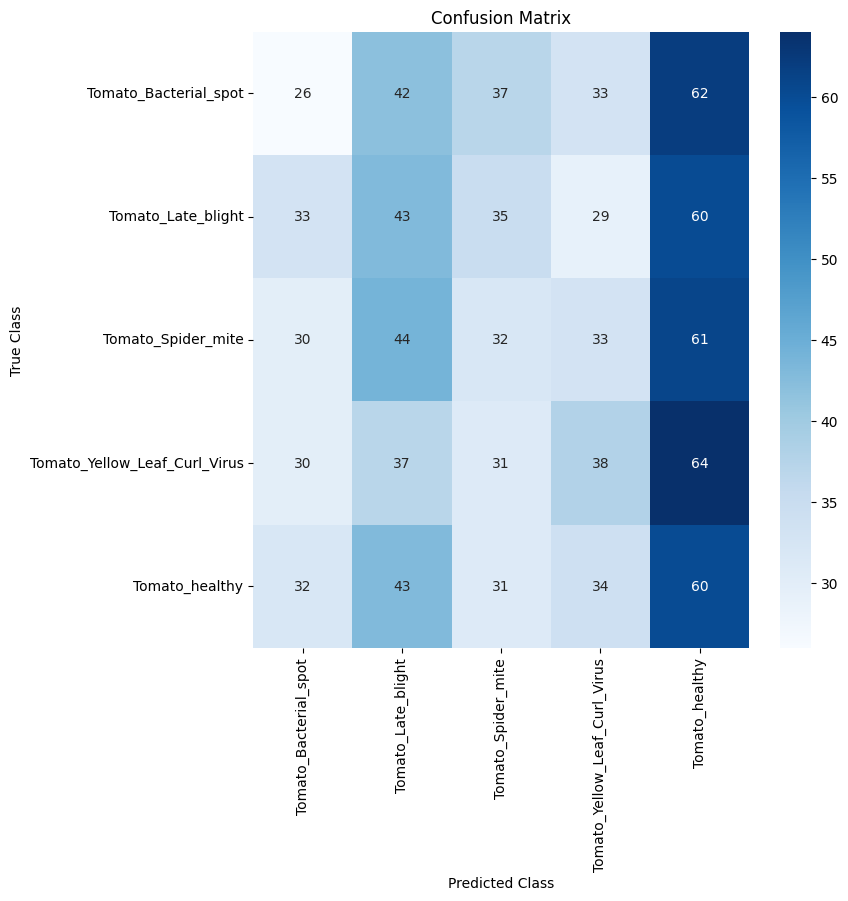

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import os

# Use the trained model to make predictions on the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Compute the test accuracy
test_acc = accuracy_score(y_true, np.argmax(y_pred, axis=1)) * 100
print(f'Test accuracy:{test_acc:.2f}')

# Generate the confusion matrix
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Define class names
class_names = sorted(os.listdir(train_dir))

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()


Text(0.5, 1.0, 'Training and Validation Loss')

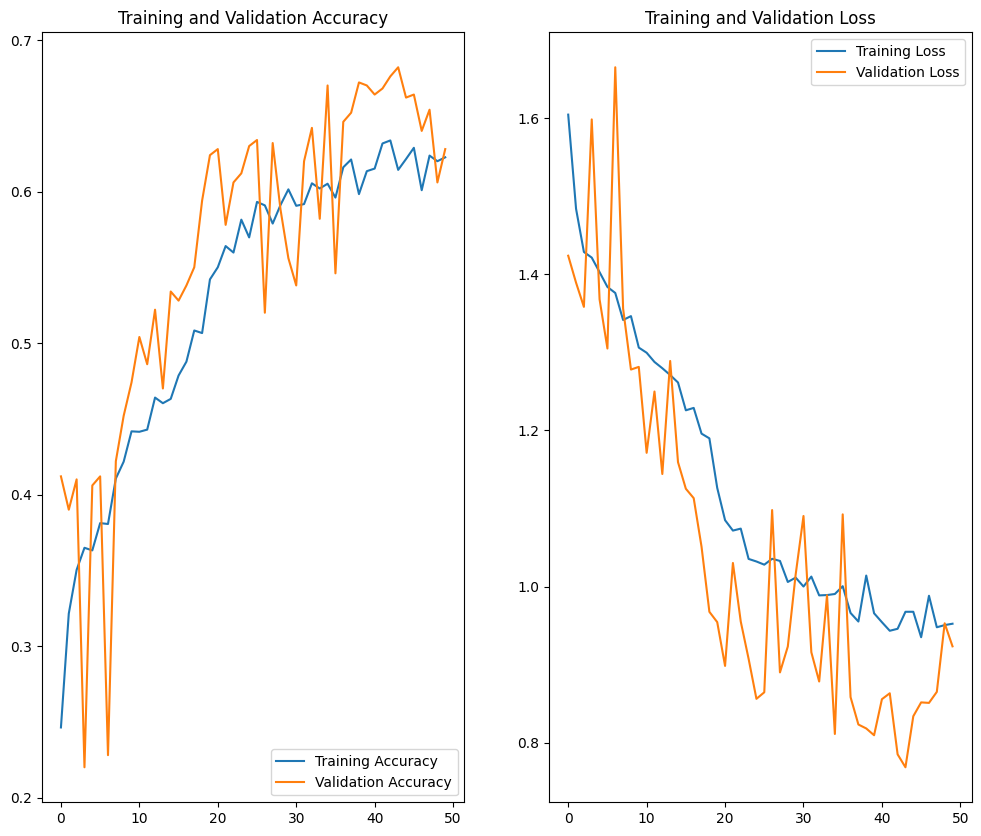

In [5]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,10))
plt.subplot(121)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(122)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [6]:
# model.save("tomatoes_pretrained.h5")

In [7]:
# # TF-Lite conversion

# # Load the Keras model
# import tensorflow as tf


# keras_model = tf.keras.models.load_model('tomatoes_pretrained.h5')

# # Convert the Keras model to TFLite format
# converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
# tflite_model = converter.convert()

# # Save the TFLite model to disk
# open("tomatoes_pretrained.tflite", "wb").write(tflite_model)
